### Problem1
#### Step1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, leastsq
from scipy.optimize import minimize
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
cmt = pd.read_csv('CMT_Rates.csv', header = 0)
cmt = cmt.dropna()

In [3]:
cmt['Date'] = pd.to_datetime(cmt.Date,format='%y/%m/%d')
cmt = cmt.set_index('Date')

In [4]:
def Nelson_Siegel(t, b1, b2, b3):
    return b1+b2*((1-np.exp(-0.4*t))/(0.4*t))+b3*((1-np.exp(-0.4*t))/(0.4*t)-np.exp(-0.4*t))

In [5]:
maturity=[1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
optimal_parameter = []
initial_b=[4, -3, 4]
for i in range(cmt.shape[0]):
    popt, pcov=curve_fit(Nelson_Siegel, maturity, cmt.iloc[i,:])
    optimal_parameter.append([popt[0],popt[1],popt[2]])
optimal_parameter = pd.DataFrame(optimal_parameter, index = cmt.index)

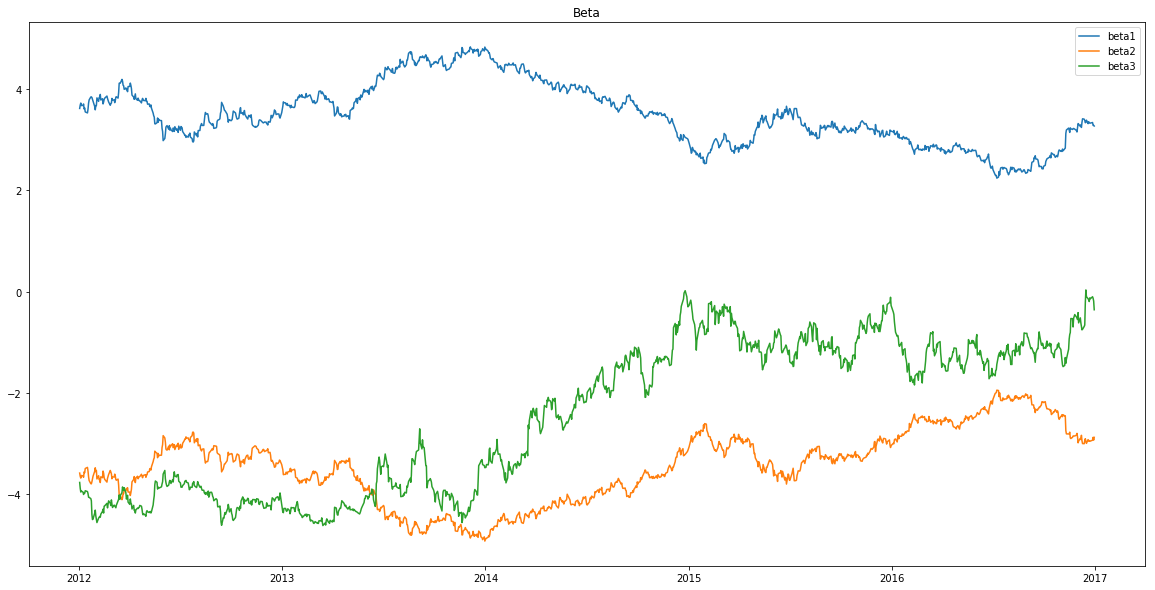

In [6]:
plt.figure(figsize=(20,10))
plt.plot(optimal_parameter.iloc[:,0])
plt.plot(optimal_parameter.iloc[:,1])
plt.plot(optimal_parameter.iloc[:,2])
plt.title('Beta')
plt.legend(['beta1','beta2','beta3'])

#### Step 2

In [7]:
def model(lam):
    maturity=[1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
    b1 = [1 for i in range(len(maturity))]
    b2 = [(1-np.exp(-lam*tau))/(lam*tau) for tau in maturity]
    b3 = [(1-np.exp(-lam*tau))/(lam*tau)-np.exp(-lam*tau) for tau in maturity]
    beta = []
    x = np.array([b1,b2,b3]).T
    for i in range(len(cmt)):
        y = np.array(cmt.iloc[i,:])
        fitted = sm.OLS(y,x).fit()
        beta.append([fitted.params[0],fitted.params[1],fitted.params[2]])
    beta = np.array(beta)
    return sum(sum((np.dot(beta,x.T)-cmt.values)**2))

In [8]:
res = minimize(model,0.036)

In [9]:
print ("Optimize Lambda is:",res.x)
print ("Optimization condition:",res.success)

Optimize Lambda is: [0.45161825]
Optimization condition: True


## Problem2 

#### Step1

In [10]:
def Nelson_Siegel1(t, b1, b2, b3, lamd):
    return b1+b2*((1-np.exp(-lamd*t))/(0.4*t))+b3*((1-np.exp(-lamd*t))/(lamd*t)-np.exp(-lamd*t))

In [11]:
def model(lam):
    maturity=[1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
    b1 = [1 for i in range(len(maturity))]
    b2 = [(1-np.exp(-lam*tau))/(lam*tau) for tau in maturity]
    b3 = [(1-np.exp(-lam*tau))/(lam*tau)-np.exp(-lam*tau) for tau in maturity]
    x = np.array([b1,b2,b3]).T
    rms = []
    beta = []
    for i in range(len(cmt)):
        pred = []
        y = np.array(cmt.iloc[i,:])
        fitted = sm.OLS(y,x).fit()
        beta.append([fitted.params[0],fitted.params[1],fitted.params[2]])
        for t in maturity:
            pred.append ( Nelson_Siegel1(t, fitted.params[0],fitted.params[1],fitted.params[2], lam))
        pred = np.array(pred) 
        rms.append( np.sqrt(mean_squared_error(cmt.iloc[i,:], pred)))
    rms = np.array(rms)
    beta = np.array(beta)
    return rms, beta

In [12]:
lam = res.x

In [13]:
rmse, beta = model(lam)
rmse = pd.DataFrame (rmse, index = cmt.index, columns=['RMSE'] )
beta = pd.DataFrame(beta, index = cmt.index,columns=['beta1', 'beta2', 'beta3'])

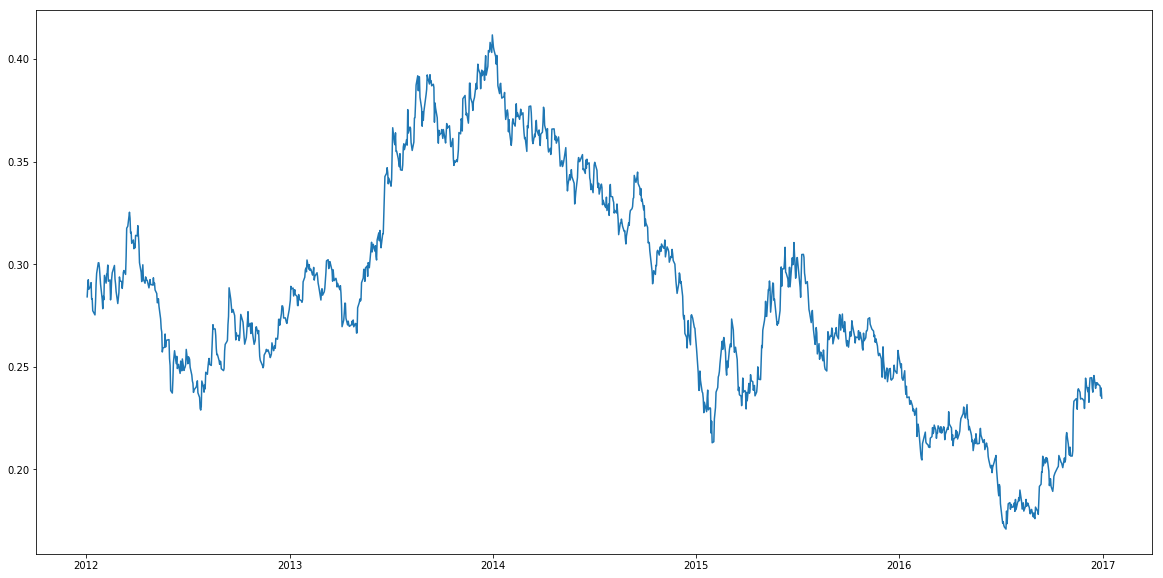

In [14]:
plt.figure(figsize=(20,10))
plt.plot(rmse)

In [15]:
largest_residual20 = rmse.sort_values(by='RMSE', ascending=False).iloc[:20, 0]
largest_residual20

Date
2013-12-31    0.411705
2013-12-27    0.408053
2014-01-02    0.405768
2014-01-03    0.404275
2013-12-24    0.404112
2013-12-26    0.403409
2013-12-30    0.403159
2014-01-08    0.401735
2013-12-19    0.401565
2014-01-06    0.401154
2013-12-05    0.397451
2014-01-07    0.397451
2013-12-18    0.396845
2013-12-23    0.396413
2014-01-09    0.396387
2013-12-06    0.395154
2013-12-12    0.394554
2013-12-16    0.394016
2013-12-09    0.392777
2013-09-10    0.392322
Name: RMSE, dtype: float64

#### Step 2

In [16]:
import statsmodels.tsa.arima_model as ar

In [17]:
import datetime
def getday(date,n=0):
    result_date = date + datetime.timedelta(days=n)
    d = result_date.strftime('%Y-%m-%d')
    return d

In [18]:
def arima_forcast(date_, beta_, forecast_days):
    begin_date = getday(date_, -180)
    pos = np.where(beta.index == date)[0][0]
    forecast = {}
    hl = {}
    for i in range(1,4):
        model = ar.ARIMA(beta.loc[begin_date:date,'beta'+str(i)], order=(1,0,0))
        model_fit = model.fit()
        forecast['beta'+str(i)]= model_fit.forecast(steps=forecast_days)[0]
        hl['beta'+str(i)] = -np.log(2)/np.log(model_fit.arparams[0])
    index = beta_.ix[(pos+1):(pos+forecast_days+1)].index
    forecast = pd.DataFrame(forecast,index = index)
    hl = pd.DataFrame(hl, index = ['half_life'])
    return forecast, hl

In [19]:
# t+5d forcast
predicted_beta5 = []
day_index5 = []
for date in largest_residual20.index:
    a, b=arima_forcast(date, beta, 5)
    predicted_beta5.append(list(a.iloc[4:].values[0]))
    day_index5.append(a.iloc[4:].index.values[0])
    #print("For day"+str(date), "the fifth predicted value is\n", a.iloc[4,:])
    print("For day"+str(date), "the half life are\n", b)

predicted_beta5_ = np.array(predicted_beta5)
predicted_beta5_ = pd.DataFrame(predicted_beta5_, index = day_index5,columns = ['beta1', 'beta2', 'beta3'])
predicted_beta5_.head()

/Users/lijinglan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

For day2013-12-31 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.361018  10.394945  16.965017
For day2013-12-27 00:00:00 the half life are
                beta1      beta2      beta3
half_life  13.175187  12.074739  15.860641
For day2014-01-02 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.276995  10.320815  15.656381
For day2014-01-03 00:00:00 the half life are
                beta1     beta2     beta3
half_life  10.491494  10.54302  15.99716
For day2013-12-24 00:00:00 the half life are
                beta1      beta2     beta3
half_life  11.560023  10.967468  15.35631
For day2013-12-26 00:00:00 the half life are
                beta1      beta2      beta3
half_life  12.278896  11.208453  16.569384
For day2013-12-30 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.996071  10.200774  15.990505
For day2014-01-08 00:00:00 the half life are
               beta1      beta2      

/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/lijinglan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy

,beta1,beta2,beta3
2014-01-08,4.691561,-4.729873,-4.101926
2014-01-06,4.671607,-4.709437,-4.054083
2014-01-09,4.652669,-4.688409,-4.096298
2014-01-10,4.655392,-4.689507,-4.046895
2014-01-02,4.623972,-4.661211,-3.995854


In [20]:
# t+10 forecast
predicted_beta10 = []
day_index10 = []
for date in largest_residual20.index:
    a, b=arima_forcast(date, beta, 10)
    predicted_beta10.append(list(a.iloc[9:].values[0]))
    day_index10.append(a.iloc[9:].index.values[0])
    #print("For day"+str(date), "the predicted value is\n", a)
    print("For day"+str(date),"the half life are\n", b)
predicted_beta10_ = np.array(predicted_beta10)
predicted_beta10_ = pd.DataFrame(predicted_beta10_, index = day_index10,columns = ['beta1', 'beta2', 'beta3'])
predicted_beta10_

/Users/lijinglan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


For day2013-12-31 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.361018  10.394945  16.965017
For day2013-12-27 00:00:00 the half life are
                beta1      beta2      beta3
half_life  13.175187  12.074739  15.860641
For day2014-01-02 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.276995  10.320815  15.656381
For day2014-01-03 00:00:00 the half life are
                beta1     beta2     beta3
half_life  10.491494  10.54302  15.99716
For day2013-12-24 00:00:00 the half life are
                beta1      beta2     beta3
half_life  11.560023  10.967468  15.35631
For day2013-12-26 00:00:00 the half life are
                beta1      beta2      beta3
half_life  12.278896  11.208453  16.569384
For day2013-12-30 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.996071  10.200774  15.990505
For day2014-01-08 00:00:00 the half life are
               beta1      beta2      

,beta1,beta2,beta3
2014-01-15,4.639352,-4.668162,-4.124158
2014-01-13,4.624850,-4.650091,-4.090278
2014-01-16,4.609061,-4.635510,-4.126866
2014-01-17,4.612223,-4.637737,-4.084395
2014-01-09,4.582391,-4.606944,-4.047423
2014-01-10,4.594744,-4.621574,-4.011962
2014-01-14,4.587770,-4.606372,-4.094529
2014-01-23,4.580240,-4.630762,-3.869802
2014-01-06,4.599239,-4.602876,-4.273602
2014-01-21,4.591311,-4.625101,-4.091238


In [22]:
# t+1m forecast
predicted_beta1m = []
day_index1m = []
for date in largest_residual20.index:
    a, b=arima_forcast(date, beta, 30)
    predicted_beta1m.append(list(a.iloc[29:].values[0]))
    day_index1m.append(a.iloc[29:].index.values[0])
    print("For day"+str(date),"the half life are\n", b)
predicted_beta1m_ = np.array(predicted_beta1m)
predicted_beta1m_ = pd.DataFrame(predicted_beta1m_, index = day_index1m,columns = ['beta1', 'beta2', 'beta3'])
predicted_beta1m_.head()

/Users/lijinglan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


For day2013-12-31 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.361018  10.394945  16.965017
For day2013-12-27 00:00:00 the half life are
                beta1      beta2      beta3
half_life  13.175187  12.074739  15.860641
For day2014-01-02 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.276995  10.320815  15.656381
For day2014-01-03 00:00:00 the half life are
                beta1     beta2     beta3
half_life  10.491494  10.54302  15.99716
For day2013-12-24 00:00:00 the half life are
                beta1      beta2     beta3
half_life  11.560023  10.967468  15.35631
For day2013-12-26 00:00:00 the half life are
                beta1      beta2      beta3
half_life  12.278896  11.208453  16.569384
For day2013-12-30 00:00:00 the half life are
                beta1      beta2      beta3
half_life  10.996071  10.200774  15.990505
For day2014-01-08 00:00:00 the half life are
               beta1      beta2      

,beta1,beta2,beta3
2014-02-13,4.542405,-4.553309,-4.178923
2014-02-11,4.523714,-4.528214,-4.176640
2014-02-14,4.528549,-4.537549,-4.199340
2014-02-18,4.531361,-4.540435,-4.174245
2014-02-07,4.499301,-4.502175,-4.168520


#### Step 3

In [23]:
maturity=[1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
b1 = [1 for i in range(len(maturity))]
b2 = [(1-np.exp(-lam*tau))/(lam*tau) for tau in maturity]
b3 = [(1-np.exp(-lam*tau))/(lam*tau)-np.exp(-lam*tau) for tau in maturity]
x = np.array([b1,b2,b3]).T

In [24]:
#calculate the forecast error of predicted value of one day
def forecastError_RM(cmt_, date_, forecast_days):
    pos = np.where(cmt_.index == date_)[0][0]
    y = cmt.iloc[(pos+forecast_days),:].values
    y_fit = cmt.iloc[pos,:].values
    squared_error = (y-y_fit)**2
    return np.sqrt(squared_error.sum()/11)

In [25]:
#calculate the forecast error of predicted value of one day
def forecastError_AR(cmt_, factor_loading, date_, predicted_beta, forecast_days):
    pos = np.where(cmt_.index == date_)[0][0]
    y = cmt.iloc[(pos+forecast_days),:].values
    y_fit = np.sum(factor_loading*predicted_beta, axis=1)
    
    squared_error = (y-y_fit)**2
    return np.sqrt(squared_error.sum()/11)

In [26]:
# t+5d total everage forcast error
total_error_ar=0
total_error_rm = 0
for i, date in enumerate(largest_residual20.index):
    total_error_ar += forecastError_AR(cmt, x, date, predicted_beta5[i], 5)
    total_error_rm += forecastError_RM(cmt, date, 5)
avg_ar = total_error_ar/20
avg_rm = total_error_rm/20
print('The total forcast error for the fifth prediction of ar model is ', avg_ar)
print('The total forcast error for the fifth prediction of random walk model is ', avg_rm)

The total forcast error for the fifth prediction of ar model is  0.12132781604010105
The total forcast error for the fifth prediction of random walk model is  0.05275015463104824


In [27]:
# t+10d total everage forcast error
total_error_ar=0
total_error_rm = 0
for i, date in enumerate(largest_residual20.index):
    total_error_ar += forecastError_AR(cmt, x, date, predicted_beta10[i], 10)
    total_error_rm += forecastError_RM(cmt, date, 10)
avg_ar = total_error_ar/20
avg_rm = total_error_rm/20
print('The total forcast error for the fifth prediction of ar model is ', avg_ar)
print('The total forcast error for the fifth prediction of random walk model is ', avg_rm)

The total forcast error for the fifth prediction of ar model is  0.1348586119031539
The total forcast error for the fifth prediction of random walk model is  0.0943249967135477


In [28]:
# t+1m total everage forcast error
total_error_ar=0
total_error_rm = 0
for i, date in enumerate(largest_residual20.index):
    total_error_ar += forecastError_AR(cmt, x, date, predicted_beta1m[i], 30)
    total_error_rm += forecastError_RM(cmt, date, 30)
avg_ar = total_error_ar/20
avg_rm = total_error_rm/20
print('The total forcast error for the fifth prediction of ar model is ', avg_ar)
print('The total forcast error for the fifth prediction of random walk model is ', avg_rm)

The total forcast error for the fifth prediction of ar model is  0.11838900243015607
The total forcast error for the fifth prediction of random walk model is  0.15947229619269637


From the above results, we could see that when the prediction date is far away from the current day, the random walk model has a poorer performance than the AR model. On the contrary, random walk model have a better performance than the AR model.